In [104]:
import numpy as np
import pandas as pd 
import os
import time
from tqdm.notebook import tqdm
import plotly.express as px
from statistics import stdev


# Finding Inconsistencies

This Notebook will be devoted to find inconsistencies within the data. 
Price fluctuations will be defined as 10 pips or more as it it minute based, where an inconsistency will be determined by a large gap in the previous close price, and the following open price.

The previous close price should be equal to the new open price, however, in most cases there is a small gap. Gaps should not be larger than 10 pips


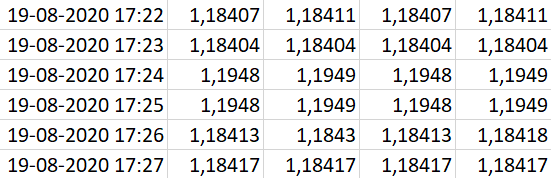

In [60]:
def load_ohlc_data(years, fx_pair, ohlc_len):
    """
    years: A list of years used.
    """
    for idx,year in enumerate(tqdm(years)):
        if ohlc_len == 1:
            temp_df = pd.read_csv("Cleaned_OHLC_FOREX_Data/{}/{}_{}_1min.csv".format(fx_pair, fx_pair,  year)).drop(columns =['Unnamed: 0'])
        elif ohlc_len == 10:
            temp_df = pd.read_csv("Cleaned_OHLC_FOREX_Data_10_min/{}/{}_{}_10min.csv".format(fx_pair, fx_pair,  year)).drop(columns =['Unnamed: 0'])
        else:
            print("OHLC_len should be 1 or 10!")
            return
            
        if idx != 0:
            ohlc_df = pd.concat([ohlc_df, temp_df], axis=0)
        else:
            ohlc_df = temp_df
           
    ohlc_df.reset_index(inplace = True, drop = True)
    return ohlc_df

df = load_ohlc_data([i for i in range(2009,2021)], "EURUSD", 1)
df



,Date_time,Open,High,Low,Close
0,2009-01-01 18:59:00,1.40050,1.40050,1.40050,1.40050
1,2009-01-01 19:00:00,1.40080,1.40080,1.40030,1.40040
2,2009-01-01 19:01:00,1.40050,1.40090,1.40050,1.40080
3,2009-01-01 19:02:00,1.40090,1.40110,1.40090,1.40110
4,2009-01-01 19:03:00,1.40090,1.40090,1.40050,1.40050
...,...,...,...,...,...
4488333,2020-12-31 16:54:00,1.22159,1.22182,1.22153,1.22175
4488334,2020-12-31 16:55:00,1.22175,1.22180,1.22170,1.22174
4488335,2020-12-31 16:56:00,1.22176,1.22179,1.22160,1.22165
4488336,2020-12-31 16:57:00,1.22166,1.22167,1.22153,1.22164


In [122]:
def print_ohlc_row(idx, prev_close, _open, close, inconsist):
    print(f"IDX: {idx}  Previous Close: {prev_close}  Open: {_open}  Close: {close}  Status: {inconsist}")
            

def report_inconsistencies_original_data(ohlc_df, verbose = False ):
    
    fluctuations = {"real":[] , "inconsistent":[] , 
                    "real_close_price_change": [] , "inconsistent_close_price_change":[] }
        
    prev_close = ohlc_df.loc[0,'Close']
    for idx,close in tqdm(enumerate(ohlc_df['Close']), total = len(ohlc_df)):
        date = ohlc_df.loc[idx,'Date_time'][8:10]
        
        if abs(close - prev_close) >= 0.0010:
            
            if (int(date) > int(prev_close)+2) or (int(date) < int(prev_close)-21):
                # If the difference in time is due to a weekend, or monthly change
                # This only activates if a price fluctuation in price is found.
                prev_date = date
                prev_close = close
                
                # Add it as a real fluctuation, as this also happens in the market
                fluctuations['real'].append(idx)
                if verbose:
                    print_ohlc_row(idx, prev_close, _open, close, "Consistent")
                    
                continue
                
            _open = ohlc_df.loc[idx,'Open']
            if abs(_open - prev_close) >= 0.0010:
                # The difference of open and close price is greathe than 15 pips.
                fluctuations['inconsistent'].append(idx)
                fluctuations['inconsistent_close_price_change'].append(abs(close - prev_close))
                if verbose:
                    print_ohlc_row(idx, prev_close, _open, close, "Inconsistent")
            else:
                # The difference of open and close price is not greater than 15 pips.
                fluctuations['real'].append(idx)
                fluctuations['real_close_price_change'].append(abs(close - prev_close))
                if verbose:
                    print_ohlc_row(idx, prev_close, _open, close, "Consistent")
                    
        
        prev_date = date
        prev_close = close
            
    return fluctuations


def report_inconsistency_data(fluctuations, year_string, total_df_len):
    
    r_mean = sum(fluctuations['real_close_price_change']) / len(fluctuations['real_close_price_change'])
    i_mean = sum(fluctuations['inconsistent_close_price_change']) / len(fluctuations['inconsistent_close_price_change'])
    
    r_stdev = stdev(fluctuations['real_close_price_change'])
    i_stdev = stdev(fluctuations['inconsistent_close_price_change'])
    
    r_max = max(fluctuations['real_close_price_change'])
    r_min = min(fluctuations['real_close_price_change'])
    i_max = max(fluctuations['inconsistent_close_price_change'])
    i_min = min(fluctuations['inconsistent_close_price_change'])
    
    print("A price fluctuation is defined as a change of 10 pips from the ")
    print("close price using 1 minute OHLC data. If the past close price, is not within 10 pips")
    print("of the open price, it is considered inconsistent.\n")
    print("")
    print("Price fluctuation statistics {}".format(year_string))
    print(f"Number of rows in dataframe            : {total_df_len}")
    print(f"Number of real fluctuations            : {len(fluctuations['real'])}")
    print(f"Number of inconsistent fluctuations    : {len(fluctuations['inconsistent'])}")
    print("")
    print(f"Mean change in close of real fluctuations                             : {r_mean:.5f}")
    print(f"Mean change in close of of inconsistent fluctuations                  : {i_mean:.5f}")
    print("")
    print(f"Standard deviation of change in close of real fluctuations            : {r_stdev:.5f}")
    print(f"Standard deviation of change in close of of inconsistent fluctuations : {i_stdev:.5f}")
    print("")
    print(f"Min, Max of change in close of real fluctuations             : {r_min:.5f}  {r_max:.5f}")
    print(f"Min, Max of change in close of of inconsistent fluctuations  : {i_min:.5f}  {i_max:.5f}")    
    
    

In [123]:
df = load_ohlc_data([i for i in range(2016,2016)], "EURUSD", 1)
fluctuations = report_inconsistencies_original_data(df, False)
report_inconsistency_data(fluctuations, "2016", len(df))


A price fluctuation is defined as a change of 10 pips from the 
close price using 1 minute OHLC data. If the past close price, is not within 10 pips
of the open price, it is considered inconsistent.


Price fluctuation statistics 2009-2019
Number of rows in dataframe            : 4110209
Number of real fluctuations            : 92776
Number of inconsistent fluctuations    : 8802

Mean change in close of real fluctuations                             : 0.00144
Mean change in close of of inconsistent fluctuations                  : 0.01484

Standard deviation of change in close of real fluctuations            : 0.00072
Standard deviation of change in close of of inconsistent fluctuations : 0.01512

Min, Max of change in close of real fluctuations             : 0.00100  0.01240
Min, Max of change in close of of inconsistent fluctuations  : 0.00100  0.10980


In [124]:
df = load_ohlc_data([i for i in range(2020,2021)], "EURUSD", 1)
fluctuations = report_inconsistencies_original_data(df, False)
report_inconsistency_data(fluctuations, "2020", len(df))


A price fluctuation is defined as a change of 10 pips from the 
close price using 1 minute OHLC data. If the past close price, is not within 10 pips
of the open price, it is considered inconsistent.


Price fluctuation statistics 2020
Number of rows in dataframe            : 378129
Number of real fluctuations            : 1820
Number of inconsistent fluctuations    : 168

Mean change in close of real fluctuations                             : 0.00140
Mean change in close of of inconsistent fluctuations                  : 0.00705

Standard deviation of change in close of real fluctuations            : 0.00074
Standard deviation of change in close of of inconsistent fluctuations : 0.00708

Min, Max of change in close of real fluctuations             : 0.00100  0.00583
Min, Max of change in close of of inconsistent fluctuations  : 0.00105  0.02420
